# Preprocessing Merfish dataset SIMPLER

We have to goals:
1. prepare the image and mask for processing
2. estimate the value of the hyper-parameters which will be used for training

In [ ]:
# conda install -c menpo ffmpeg

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import torch
import numpy as np
import collections
from MODULES.preprocessing import *
from MODULES.namedtuple import ImageBbox, PreProcess
from MODULES.utilities import save_obj, load_obj
from typing import Optional

## Use coarse resolution image to estimate the parameters

Define the parameters specific to this dataset

In [3]:
file= "smFISH_stitched_OLEH.tif"
mode = "F"  # options are: I, RGB, L, F
outside_ROI = "zero" # options are: mean, zero

import skimage.filters
import skimage.morphology
import skimage.color

def find_ROI_mask(img_GRAY):
    """ Find the region of interest by thresholding """
    thresh = skimage.filters.threshold_otsu(img_GRAY)
    return skimage.morphology.convex_hull_image(img_GRAY > thresh) * (img_GRAY > 1E-6)

def find_NUCLEI_mask(img_GRAY, ROI_mask):
    """ Find the nuclei by doing another thresholding inside the ROI """
    thresh = skimage.filters.threshold_otsu(img_GRAY)
    return (img_GRAY > thresh) * ROI_mask

### 0. Open the raw image

In [4]:
array = pil_to_numpy(file, mode)
print(array.shape)

(21505, 21505)


### 1. Reduce the size and get gray image

In [5]:
reduction_factor=8
img = skimage.transform.rescale(array, scale=1.0/reduction_factor, order=1, mode='constant', cval=0, 
                                clip=True, preserve_range=False, 
                                multichannel=(len(array.shape) ==3), 
                                anti_aliasing=True)

In [6]:
if len(img.shape) == 3:
    img_gray = skimage.color.rgb2gray(img)
elif len(img.shape) == 2:
    img_gray = skimage.img_as_float(img)
else:
    raise Exception("You should never be here")
    
print("shape, dtype -->",img.shape, img.dtype)
print("shape, dtype -->",img_gray.shape, img_gray.dtype)

shape, dtype --> (2688, 2688) float32
shape, dtype --> (2688, 2688) float32


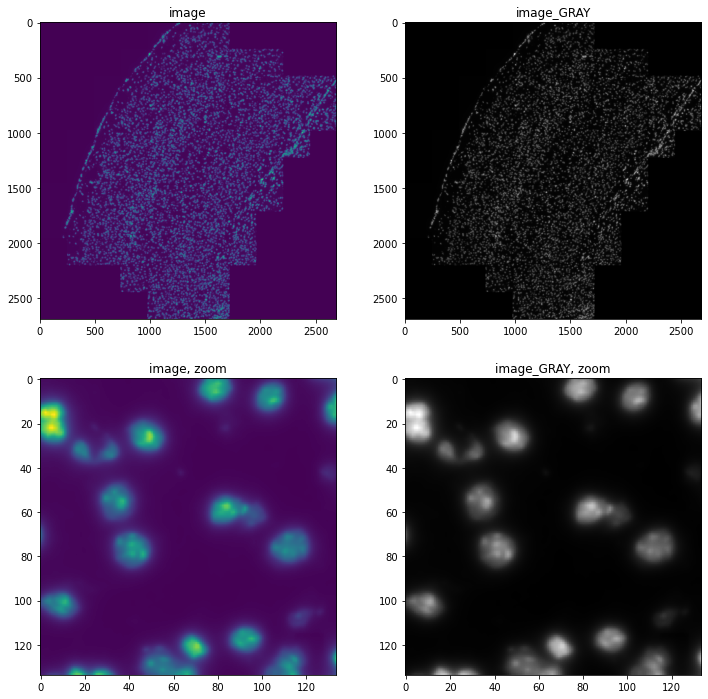

In [7]:
x,y,delta = img_gray.shape[0]//2,img_gray.shape[1]//2,img_gray.shape[0]//20
window = (x,y,x+delta,y+delta)
plot_img_and_zoom(img=img, 
                  img_gray=img_gray, 
                  window=window, 
                  figsize=(12,12))

### 1. Find the ROI_mask by thresholding 

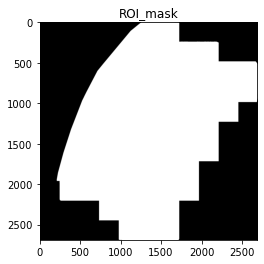

In [8]:
ROI_mask = find_ROI_mask(img_gray)

plt.imshow(ROI_mask, cmap='gray')
_ = plt.title("ROI_mask")

### 2. Set the region outside ROI to either ZERO or MEAN

In [9]:
if outside_ROI == "zero":
    GRAY_channel_inside_ROI = 0 
    channel_inside_ROI = 0 
elif outside_ROI == "mean":
    GRAY_channel_inside_ROI = np.mean(img_gray[ROI_mask]).astype(img_gray.dtype)
    channel_inside_ROI = np.mean(img[ROI_mask], axis=0).astype(img.dtype)
    
print("GRAY_channel_inside_ROI",GRAY_channel_inside_ROI)
print("channel_inside_ROI",channel_inside_ROI)

img[~ROI_mask] = channel_inside_ROI
img_gray[~ROI_mask] = GRAY_channel_inside_ROI

GRAY_channel_inside_ROI 0
channel_inside_ROI 0


### 4. Find the nuclei
by performing an additional thresholdoing inside the ROI.

In [10]:
NUCLEI_mask = find_NUCLEI_mask(img_gray, ROI_mask)

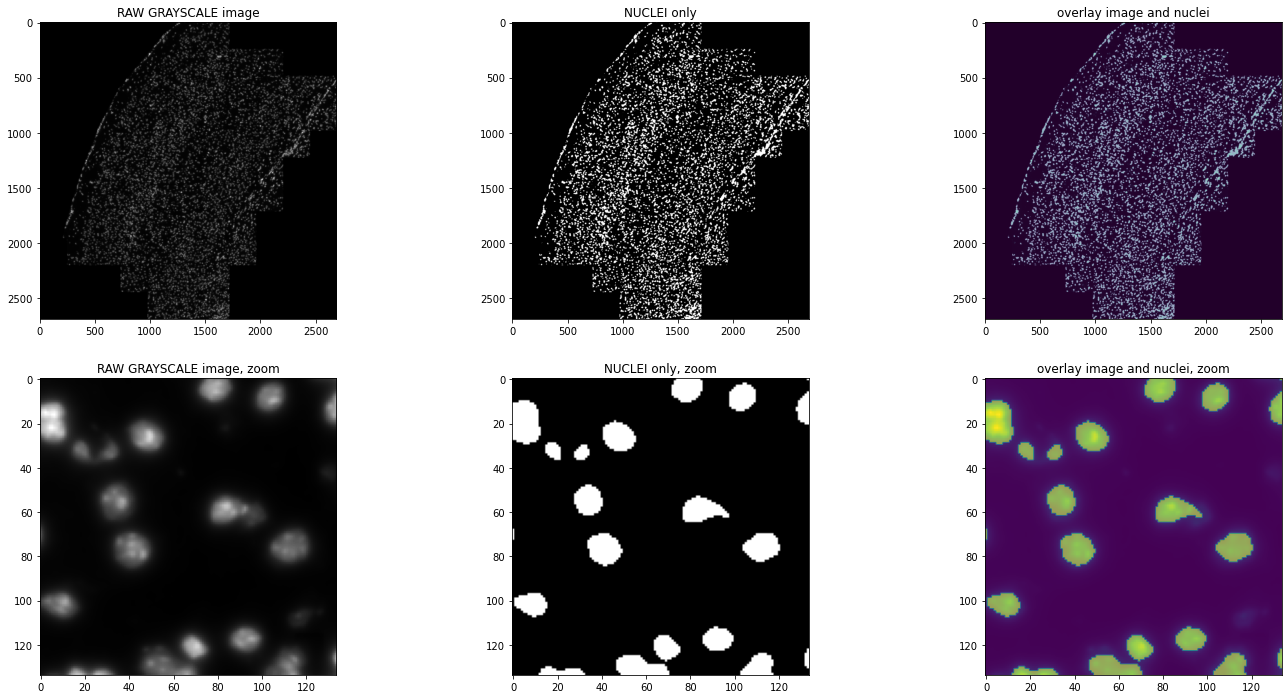

In [11]:
plot_img_and_nuclei(img_gray=img_gray, 
                    NUCLEI_mask=NUCLEI_mask, 
                    window = window, 
                    figsize=(24, 12))

In [53]:
print("np.sum(small_NUCLEI_mask) ------>",np.sum(NUCLEI_mask))
print("np.sum(small_ROI_mask) ->",np.sum(ROI_mask))
print("Estimated fraction NUCLEI_pixel -->",float(np.sum(NUCLEI_mask))/np.sum(ROI_mask))

np.sum(small_NUCLEI_mask) ------> 3310708
np.sum(small_ROI_mask) -> 16527563
Estimated fraction NUCLEI_pixel --> 0.2003143476143458


### 5. Set bg to zero (optional)

In [12]:
img[~NUCLEI_mask] = 0
img_gray[~NUCLEI_mask] = 0

### 6. Adjust the contrrast 
Use adaptive equalization 
Play with the parameters to find a good preprocessing.
The same (properly rescaled) parameters will be used for the large resolution image.

In [13]:
kernel_size = None
clip_limit = 0.01
rescaled_img = skimage.exposure.equalize_adapthist(img, kernel_size=kernel_size, clip_limit=clip_limit)
rescaled_img_gray = skimage.exposure.equalize_adapthist(img_gray, kernel_size=kernel_size, clip_limit=clip_limit)

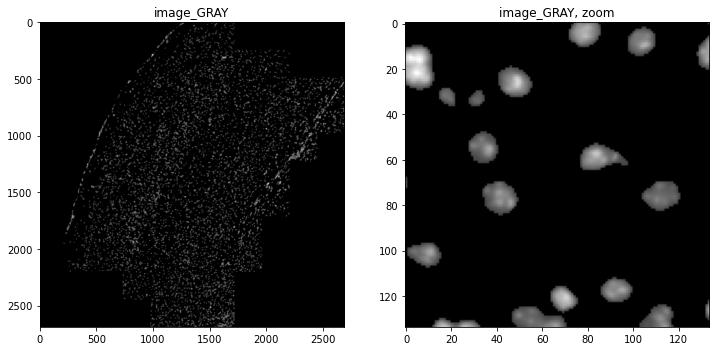

In [14]:
plot_img_and_zoom(img_gray=img_gray, 
                  window=window, 
                  figsize=(12,12))

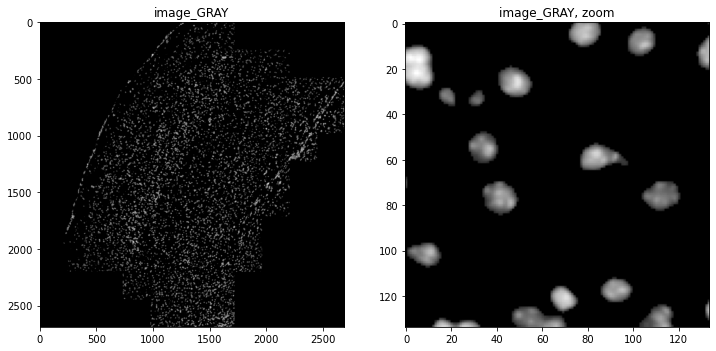

In [15]:
plot_img_and_zoom(img_gray=rescaled_img_gray, 
                  window=window, 
                  figsize=(12, 12))

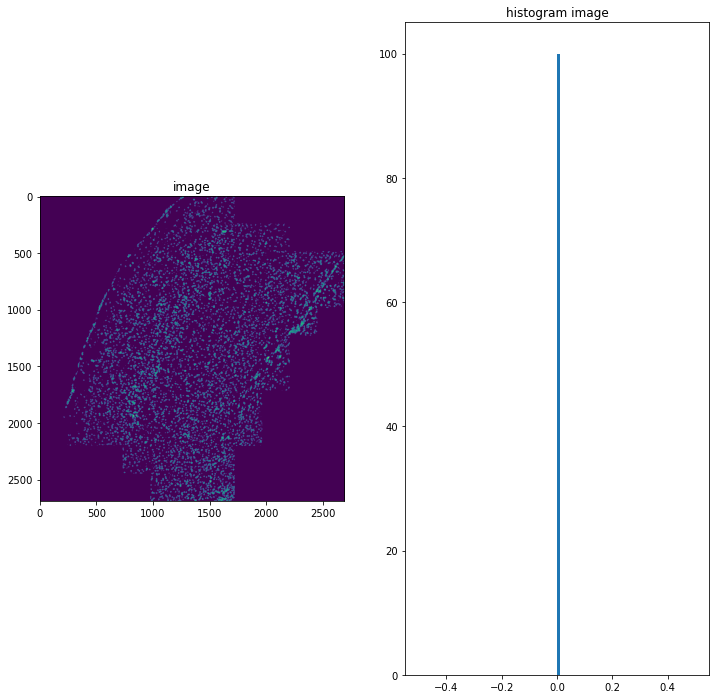

In [16]:
plot_img_and_histo(img=rescaled_img_gray,  
                   histo_mask=ROI_mask * ~NUCLEI_mask, 
                   figsize=(12,12)) 

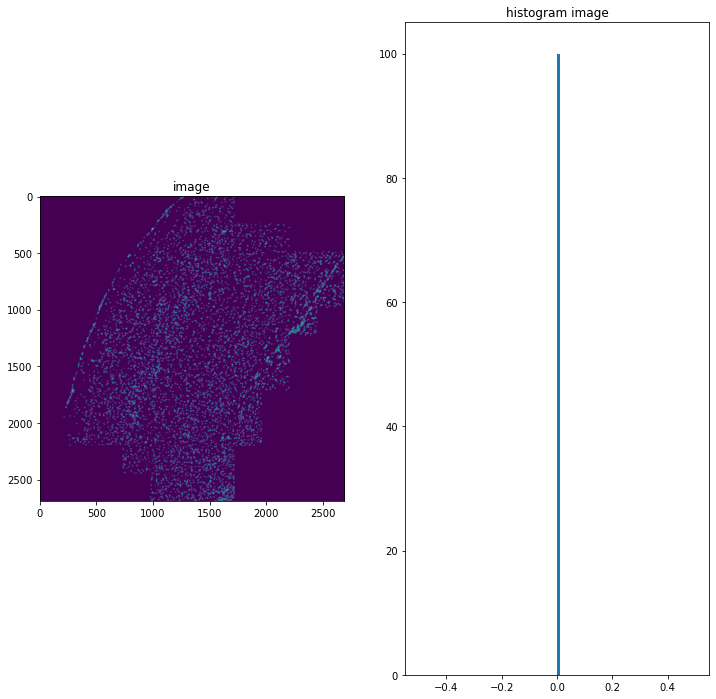

In [17]:
plot_img_and_histo(img=img_gray,  
                   histo_mask=ROI_mask * ~NUCLEI_mask, 
                   figsize=(12,12)) 

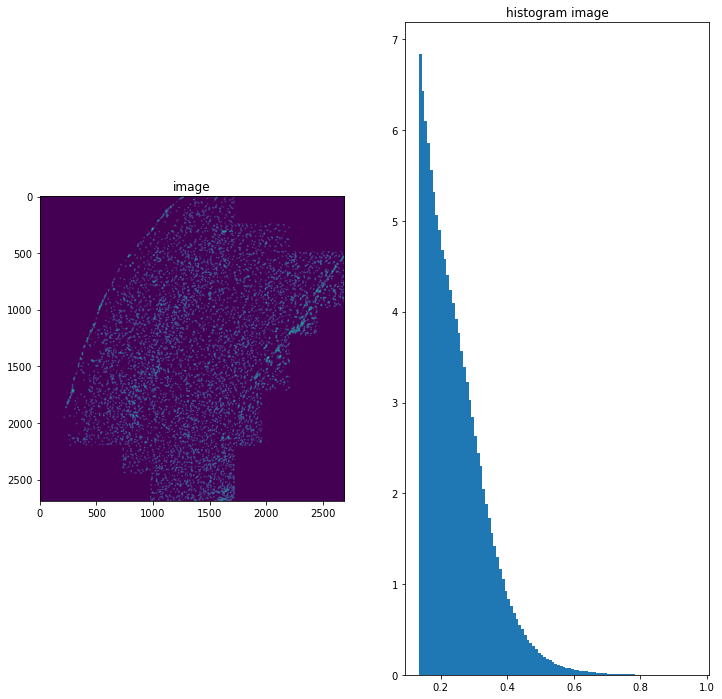

In [19]:
plot_img_and_histo(img=img_gray,  
                   histo_mask=ROI_mask * NUCLEI_mask, 
                   figsize=(12,12)) 

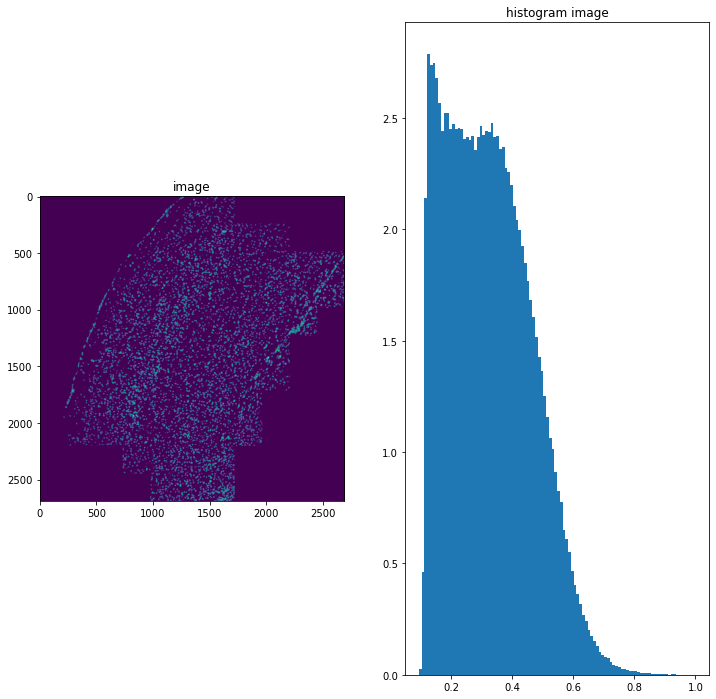

In [20]:
plot_img_and_histo(img=rescaled_img_gray,  
                   histo_mask=ROI_mask * NUCLEI_mask, 
                   figsize=(12,12)) 

### 7. Estimate MSE
Deteriorate the image by applying gaussian filter with increasing spatial support. Note that after the gaussian filters the image is converted to float in range (0,1)

In [21]:
smoothed = gaussian_smoothing(img, sigma_gaussian_filter = np.arange(0,10))
mse = compute_sqrt_mse(smoothed, roi_mask=ROI_mask)

html = show_video(frames=smoothed[:,window[0]:window[2],window[1]:window[3]], 
                  ref_image=smoothed[0,window[0]:window[2],window[1]:window[3]],
                  mse=mse,
                  interval=500)


In [22]:
#with open('html_file.html', 'w') as f:
#    f.write(html.data)

html

### 7. Prepare for export

In [23]:
bbox_original= ImageBbox(min_row=0,
                         min_col=0,
                         max_row=array.shape[0],
                         max_col=array.shape[1])

#bbox_crop = find_bbox(ROI_mask)

bbox_crop = ImageBbox(min_row=0,
                      min_col=0,
                      max_row=img.shape[0],
                      max_col=img.shape[1])
print(bbox_original)
print(bbox_crop)

#crop_img = img[bbox_crop.min_row:bbox_crop.max_row,
#               bbox_crop.min_col:bbox_crop.max_col]
#crop_ROI_mask = ROI_mask[bbox_crop.min_row:bbox_crop.max_row,
#                         bbox_crop.min_col:bbox_crop.max_col]

ImageBbox(min_row=0, min_col=0, max_row=21505, max_col=21505)
ImageBbox(min_row=0, min_col=0, max_row=2688, max_col=2688)


In [24]:
import torchvision.transforms as transforms

tmp=PreProcess(img=transforms.ToTensor()(img)[None],
               roi_mask=transforms.ToTensor()(ROI_mask)[None],
               bbox_original=bbox_original,
               bbox_crop=bbox_crop)
print(tmp.img.shape)
print(tmp.roi_mask.shape)
assert len(tmp.img.shape) == len(tmp.roi_mask.shape) == 4

torch.Size([1, 1, 2688, 2688])
torch.Size([1, 1, 2688, 2688])


### 8. Check one more time before saving

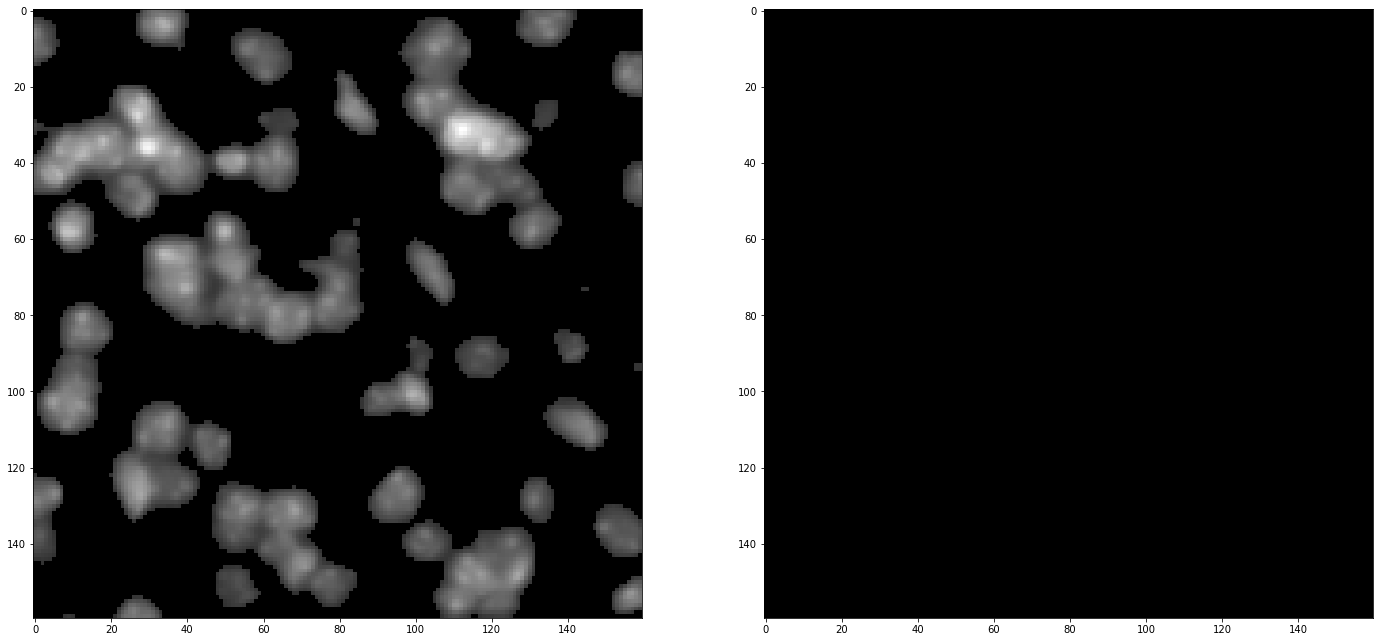

In [27]:
show_random_examples(tmp.img[0,0], size=160, nexamples=2, ncols=2, figsize=(24,24))

### 9. Save

In [28]:
f = "preprocessed_bgZERO_"+str(reduction_factor)+"_"+file

save_obj(tmp, f)
print(f)
a = load_obj(f)

preprocessed_bgZERO_8_smFISH_stitched_OLEH.tif
